# QC Parcels Output - Particle Movement Summary

In [ ]:
import glob 
import os 

import numpy as np
import random
# from collections.abc import Iterable
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import imageio 

from sklearn.datasets import make_blobs
from tools.toolz import PerlinNoise, PerlinNoiseThreshold
from noise import pnoise2


In [ ]:
# import seaborn as sns
# sns.displot(flat_noise, kind="kde")

In [249]:
# Run example
for i in range(0,10):
    particles = PerlinNoise(
        n_particles=5000,
        grid_size=(300, 300),
        scale=random.randint(10, 100),
        seed=random.randint(0, 1999),
        octaves=random.randint(1, 6),
        persistence=random.uniform(0.3, 0.7),
        lacunarity=random.uniform(1.5, 3.5),
        plot=False
    )

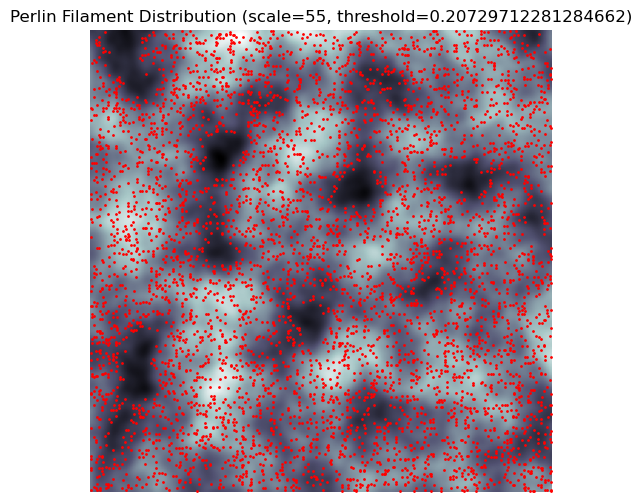

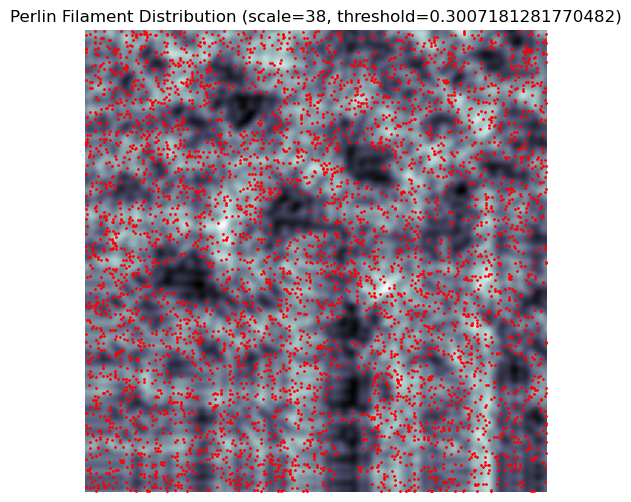

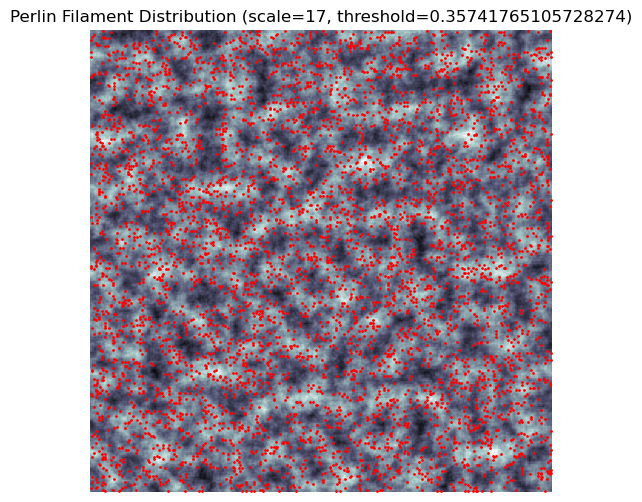

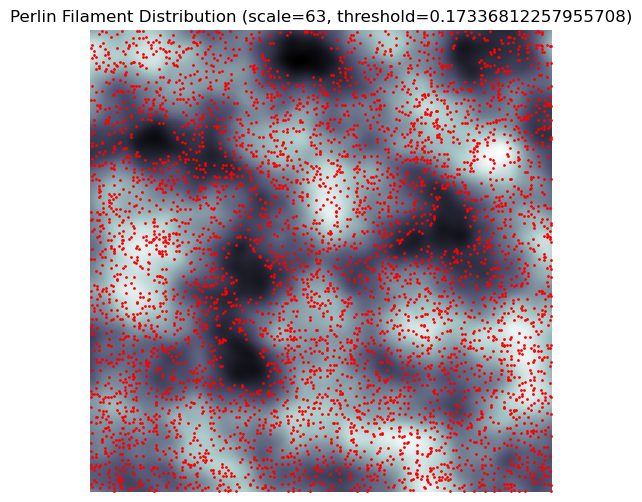

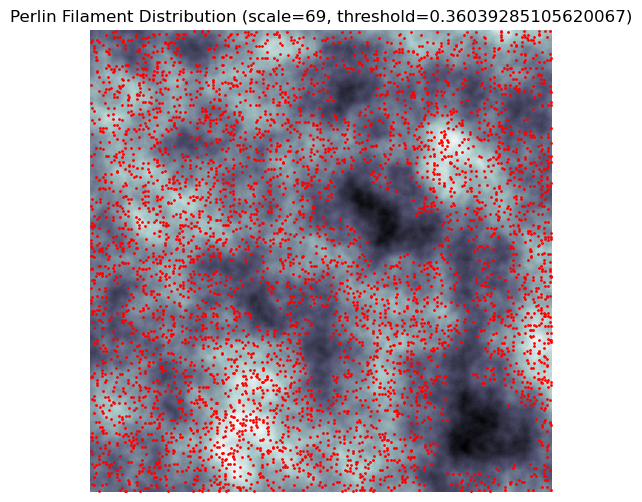

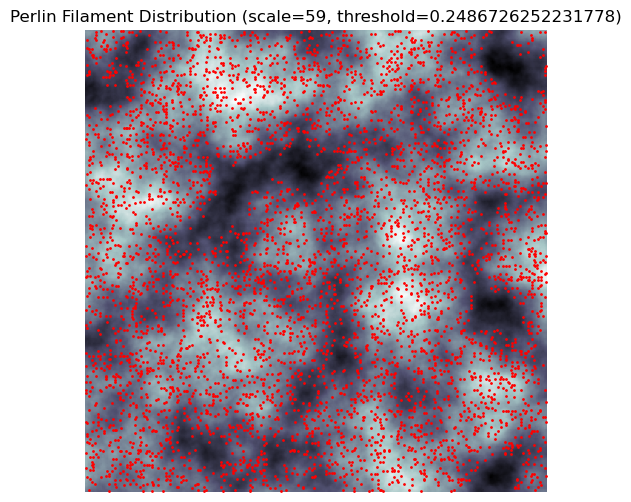

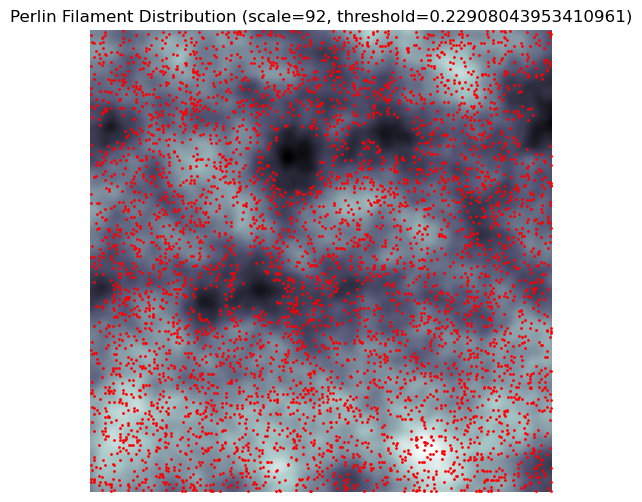

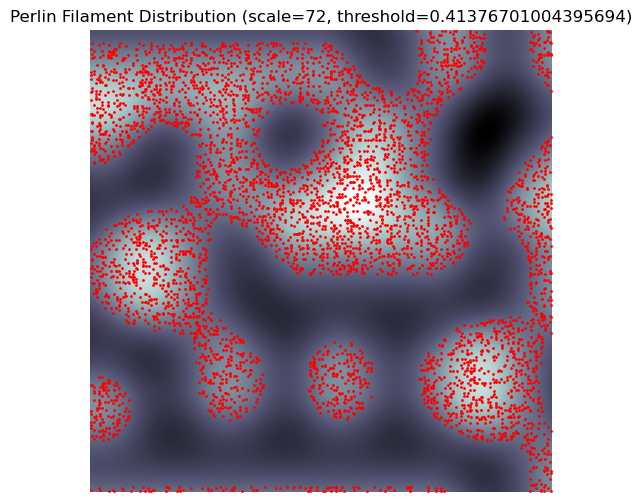

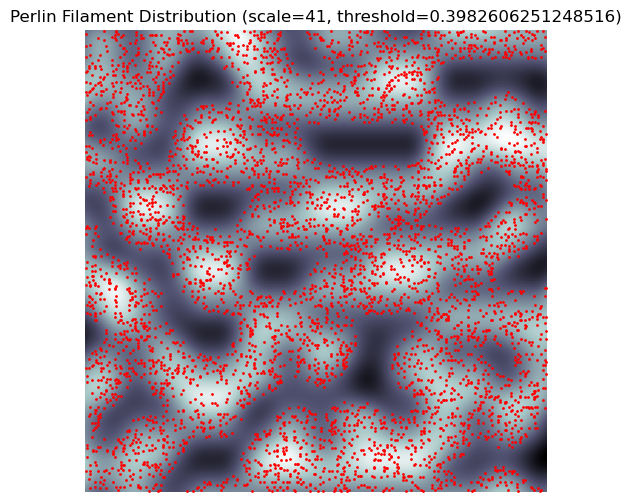

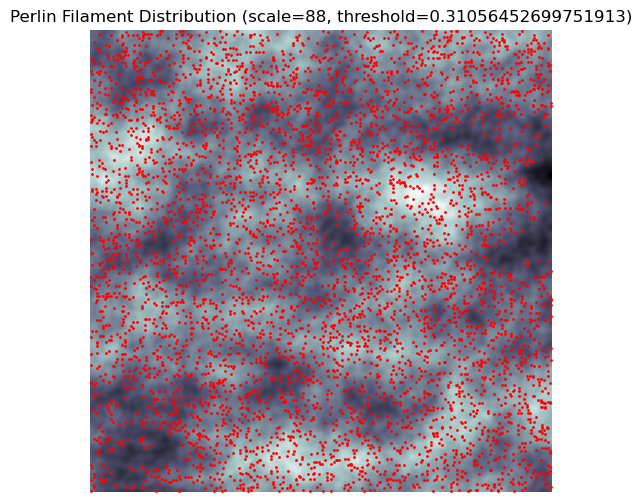

In [263]:
# Run example
for i in range(0,10):
    particles = PerlinNoiseThreshold(
        n_particles=5000,
        grid_size=(300, 300),
        scale=random.randint(10, 100),
        threshold=random.uniform(0.05, 0.5),
        seed=random.randint(0, 1999),
        octaves=random.randint(1, 6),
        persistence=random.uniform(0.3, 0.7),
        lacunarity=random.uniform(1.5, 3.5),
        plot=True
    )

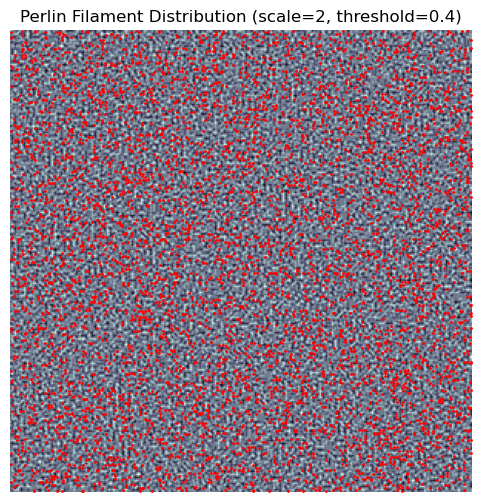

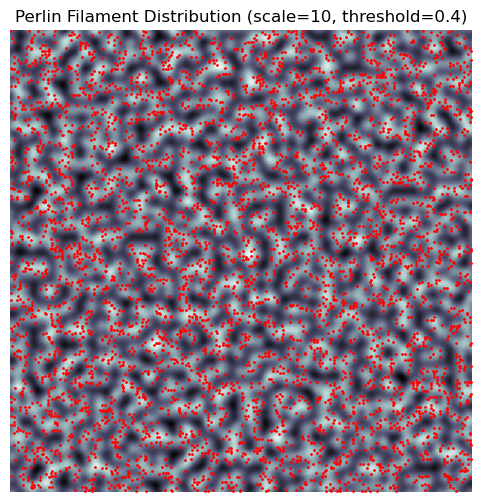

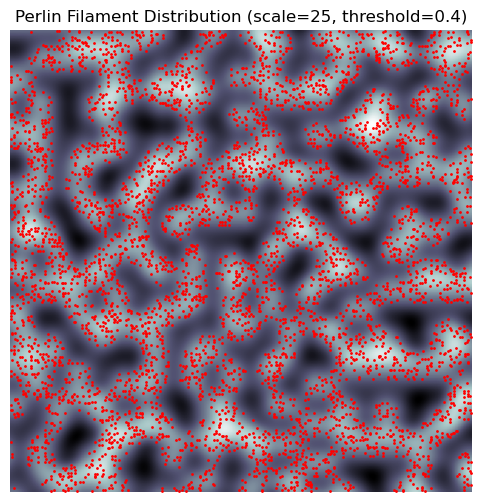

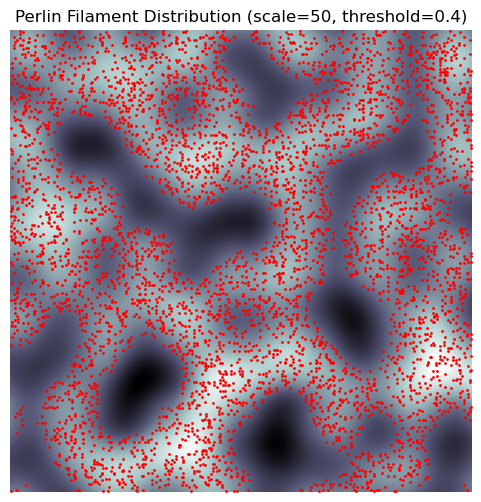

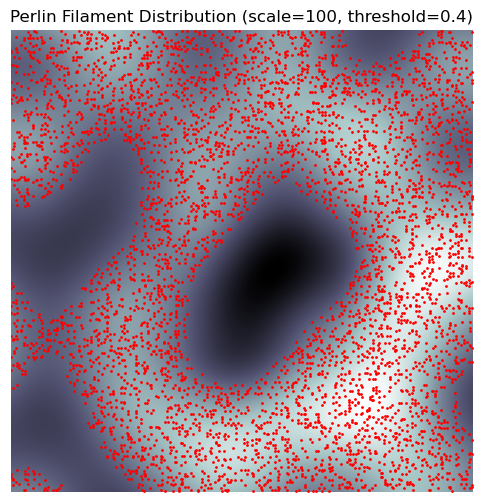

In [203]:
scales = [2, 10, 25, 50, 100]
# thresholds = [0.1, 0.3, 0.5]
thresholds = [0.4]
seed=random.randint(0, 100)

for scale in scales:
    for t in thresholds: 
        particles = generate_particles_with_perlin(
            n_particles=5000,
            grid_size=(300, 300),
            scale=scale,
            threshold=t,
            seed=seed,
            octaves=1, # controls level of detail. Higher = more structure.
            persistence=0.3, # amplitude change between octaves. Try 0.3–0.6.
            lacunarity=2.5 # frequency change between octaves. 1.5–2.5 works well.
        )

# repeatx/repeaty: Makes the noise repeat — useful for tiled domains.
# base: Seed for randomness (change to vary results).

In [31]:
# Parameters
d = 50  # particles per km²
A = 1 * 111  # km²
n = int(d * A)  # total number of particles

centers = [10, 25, 50, 100]  # number of blob centers
cluster_stds = [10, 25, 50, 100]

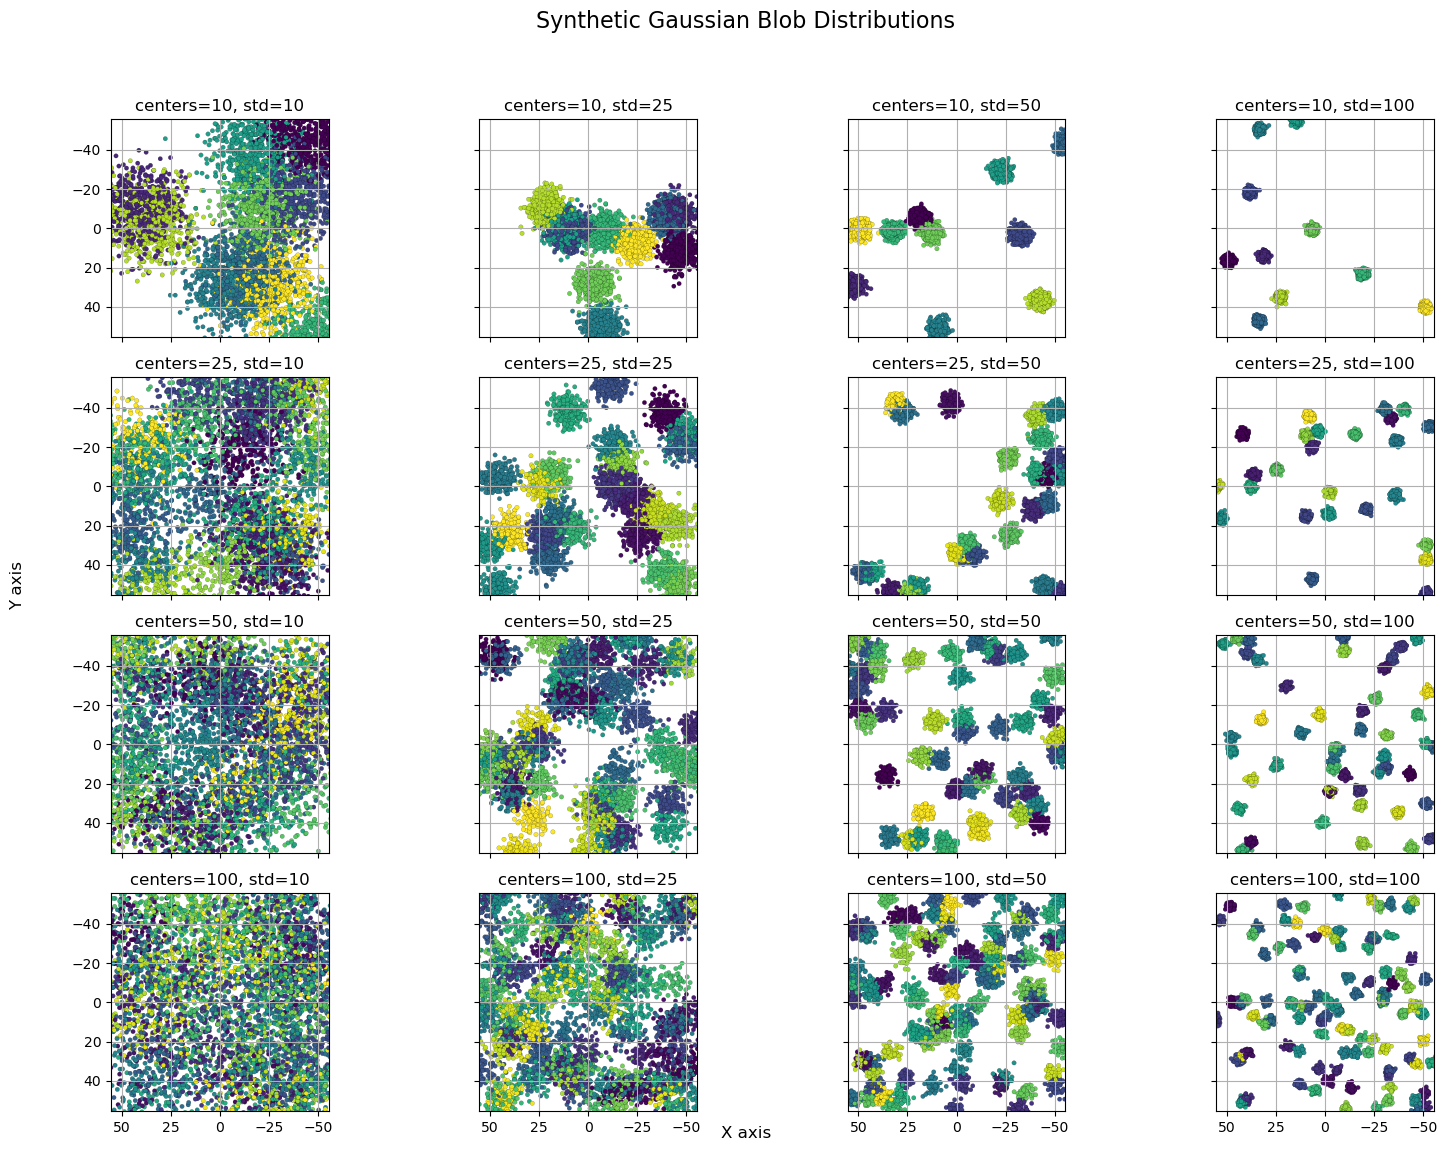

In [16]:
# Create figure and axes
fig, axes = plt.subplots(len(centers), len(cluster_stds), figsize=(16, 12), sharex=True, sharey=True)

for i, center in enumerate(centers):
    for j, std in enumerate(cluster_stds):
        n_samples = n
        cluster_std = A / std
        cluster_box = (A / 2, -A / 2)
        x, labels = make_blobs(
            n_samples=n_samples,
            random_state=None,
            centers=center,
            cluster_std=cluster_std,
            center_box=cluster_box,
        )

        ax = axes[i, j]
        ax.scatter(x[:, 0], x[:, 1], c=labels, cmap='viridis', s=10, edgecolor='k', linewidth=0.1)
        ax.set_title(f"centers={center}, std={std}")
        ax.set_aspect("equal")
        ax.grid(True)
        ax.set_xlim(cluster_box)
        ax.set_ylim(cluster_box)

# Shared labels
fig.text(0.5, 0.04, 'X axis', ha='center', fontsize=12)
fig.text(0.04, 0.5, 'Y axis', va='center', rotation='vertical', fontsize=12)
fig.suptitle("Synthetic Gaussian Blob Distributions", fontsize=16)
plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
plt.show()

In [ ]:
def plot_initial_final(ds):
    # --- Extract Initial and Final Positions ---
    initial = ds.isel(obs=0)
    final = ds.isel(obs=-1)

    # --- Plot: Initial and Final Positions ---
    fig, ax = plt.subplots(figsize=(6, 4), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.scatter(initial.lon, initial.lat, color='blue', s=10, label='Initial', transform=ccrs.PlateCarree())
    ax.scatter(final.lon, final.lat, color='red', s=10, label='Final', transform=ccrs.PlateCarree())

    ax.coastlines()
    ax.gridlines(draw_labels=True)
    ax.set_title("Initial vs Final Particle Positions")
    ax.legend()
    plt.tight_layout()
    plt.show()

def plot_trajectory(ds):
    # --- Plot: Trajectories Over Time ---
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    n_traj = min(50, ds.dims["trajectory"])  # Show up to 50 tracks

    for i in range(n_traj):
        ax.plot(ds.lon.isel(trajectory=i), ds.lat.isel(trajectory=i), alpha=0.7, linewidth=1)

    ax.coastlines()
    ax.gridlines(draw_labels=True)
    ax.set_title("Particle Trajectories Over Time")
    plt.tight_layout()
    plt.show()

def make_gif(ds, folder):
    file_name = folder.split("/")[-1].split(".zarr")[0]
    output_dir = "/Users/mattiaromero/Projects/R&D/2025 Projects/Hotspot Hunting Project/AWS Hackathon/figures"
    os.makedirs(output_dir, exist_ok=True)
    frames = []
    for i in range(24):
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.scatter(ds.isel(obs=(10*i)).lat, ds.isel(obs=(10*i)).lon, color='blue', s=10)
        ax.set_title(f"Time since start: {i}h")
        filename = os.path.join(output_dir, f"{file_name}_frame_{i:03d}.png")
        plt.savefig(filename)
        plt.close()
        frames.append(filename)

    # Step 4: Create GIF
    images = [imageio.imread(f) for f in frames]
    imageio.mimsave(f"{output_dir}/{file_name}.gif", images, fps=4)

    # Optional: Clean up frame images
    for f in frames:
        os.remove(f)

In [266]:
paths = []
folders = glob.glob(f"/Users/mattiaromero/Data/parcels/AWSHackathon/*")
for folder in folders[50:55]: 
    paths.append(folder)
    ds = xr.open_zarr(folder)
    # plot_initial_final(ds)
    # plot_trajectory(ds)
    make_gif(ds, folder)

/var/folders/hv/r17r9h7n5mj302dkpd8q4zcr0000gn/T/ipykernel_76879/3456152097.py:47: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(f) for f in frames]
/var/folders/hv/r17r9h7n5mj302dkpd8q4zcr0000gn/T/ipykernel_76879/3456152097.py:47: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(f) for f in frames]
/var/folders/hv/r17r9h7n5mj302dkpd8q4zcr0000gn/T/ipykernel_76879/3456152097.py:47: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this wa

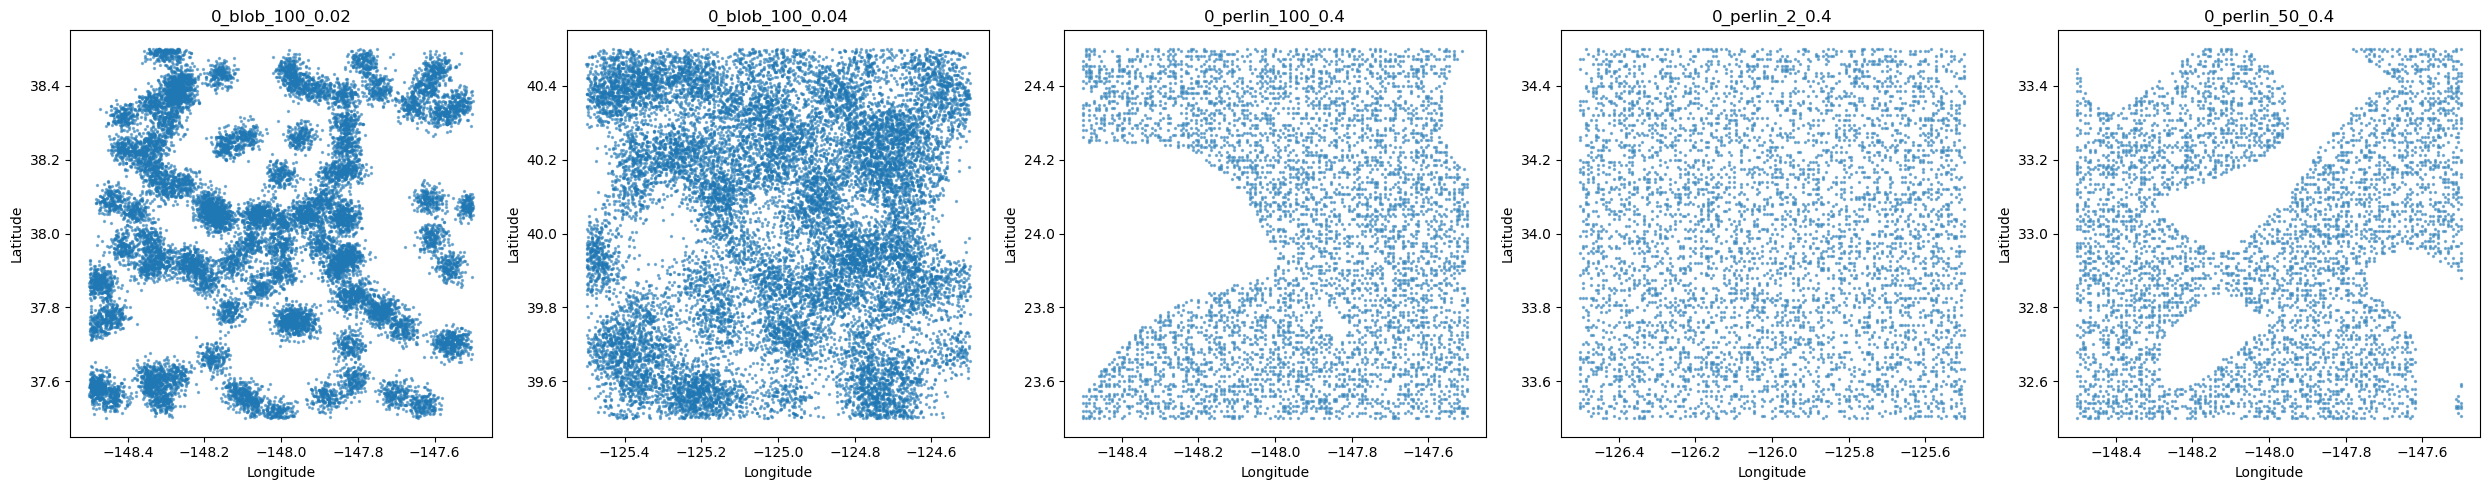

In [109]:
# Path to your folder containing .zarr datasets
zarr_folder = "/Users/mattiaromero/Data/parcels/drones2/"
zarr_paths = sorted(glob.glob(os.path.join(zarr_folder, "0_*.zarr")))

# Load only the first timestep of lon/lat for each dataset
fig, axes = plt.subplots(1, len(zarr_paths), figsize=(5 * len(zarr_paths), 5))

if len(zarr_paths) == 1:
    axes = [axes]

for ax, zarr_path in zip(axes, zarr_paths):
    ds = xr.open_zarr(zarr_path)
    
    # Select initial time step (obs=0) and all trajectories
    try:
        lat0 = ds["lat"].isel(obs=0)
        lon0 = ds["lon"].isel(obs=0)
    except KeyError:
        raise KeyError(f"lat or lon not found in {zarr_path}")

    ax.scatter(lon0, lat0, s=2, alpha=0.5)
    ax.set_title(os.path.basename(zarr_path.split("_Particles")[0]))
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

plt.tight_layout()
plt.show()